# TESScut WCS discrepancy exploration

Clara Brasseur
Jeff Valenti

In [1]:
import numpy as np
from itertools import product

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy.table import Table,Column

from astroquery.mast import Tesscut
from astroquery.mast import Catalogs

from wcs_fitting import pixworld2wcs

In [2]:
tic_ra=107.44973 
tic_dec=-70.67401
coord = SkyCoord(tic_ra,tic_dec,unit='deg')
cutout = Tesscut.get_cutouts(coord,[25,30],sector=1)
mycut = cutout[0]

In [4]:
cutout_img = mycut[1].data[600]['FLUX']

cutout_wcs = wcs.WCS(mycut[2].header,relax=True)
cutout_wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 111.99416351318  -65.052307128906  
CRPIX : 198.0  -985.0  
PC1_1 PC1_2  : -0.0051061934791505  -0.0024046150501817  
PC2_1 PC2_2  : 0.0025374281685799  -0.0051685790531337  
CDELT : 1.0  1.0  
NAXIS : 30  25

## Question

Why does one of these plots look fine and the other does not?

In [3]:
nearbyStars = Catalogs.query_region(coord,catalog="tic",radius=0.1)

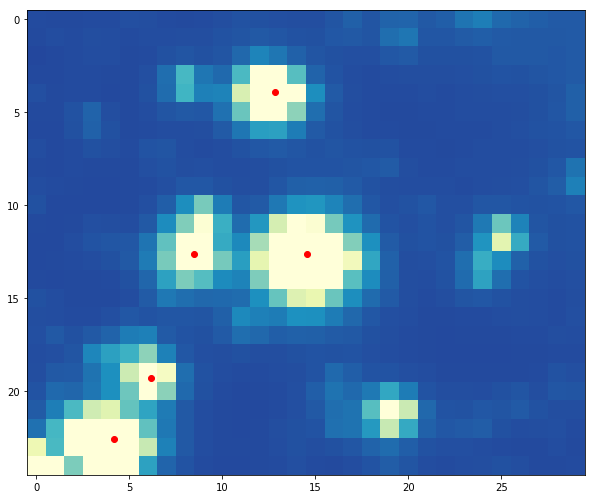

In [5]:
fig, ax = plt.subplots()
ax.imshow(cutout_img, cmap=plt.cm.YlGnBu_r,vmin=0,vmax=500)
fig.set_size_inches(10,10)

px,py = cutout_wcs.all_world2pix(nearbyStars[nearbyStars['Tmag'] < 12]['ra'],
                                  nearbyStars[nearbyStars['Tmag'] < 12]['dec'],0)
ax.plot(px,py,'o',color="red")

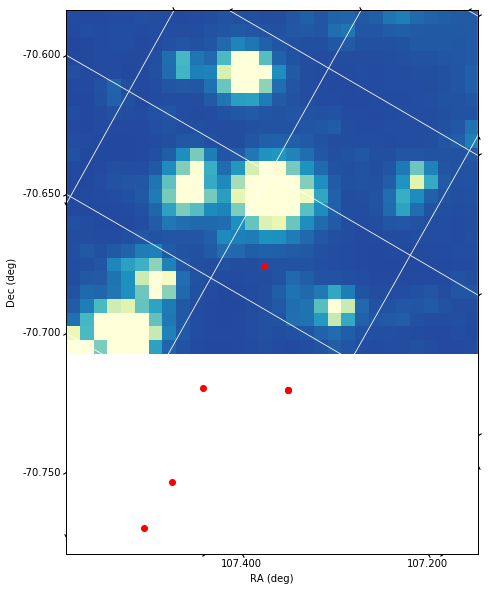

In [6]:
fig, ax = plt.subplots(subplot_kw={'projection':cutout_wcs})
fig.set_size_inches(10,10)
plt.grid(color='white', ls='solid')
    
# Setup WCS axes.
xcoords = ax.coords[0]
ycoords = ax.coords[1]
xcoords.set_major_formatter('d.ddd')
ycoords.set_major_formatter('d.ddd')
xcoords.set_axislabel("RA (deg)")
ycoords.set_axislabel("Dec (deg)")
ax.imshow(cutout_img, cmap=plt.cm.YlGnBu_r,vmin=0,vmax=500)
ax.plot([tic_ra], [tic_dec], 'ko', transform=ax.get_transform('icrs'))
ax.plot(nearbyStars[nearbyStars['Tmag'] < 12]['ra'],nearbyStars[nearbyStars['Tmag'] < 12]['dec'],
        'o',transform=ax.get_transform('icrs'),color="red")

plt.show()

## Answer

WCSAxes, which creates the wcs projection for the plot does not take into account the SIP distortions (it uses wcs.wcs_world2pix rather than wcs.all_world2pix).

#### How big a difference can that make?

In [7]:
print(cutout_wcs.all_world2pix([[tic_ra,tic_dec]],0))
print(cutout_wcs.wcs_world2pix([[tic_ra,tic_dec]],0))

[[14.57452012 12.6464274 ]]
[[15.66636956 27.14389852]]


#### Why the big discrepancy in the y values?

In [14]:
fits_file = "https://archive.stsci.edu/missions/tess/ffi/s0001/2018/221/4-3/tess2018221072942-s0001-4-3-0120-s_ffic.fits"
ffi_hdu = fits.open(fits_file)
ffi_wcs = wcs.WCS(ffi_hdu[1].header)

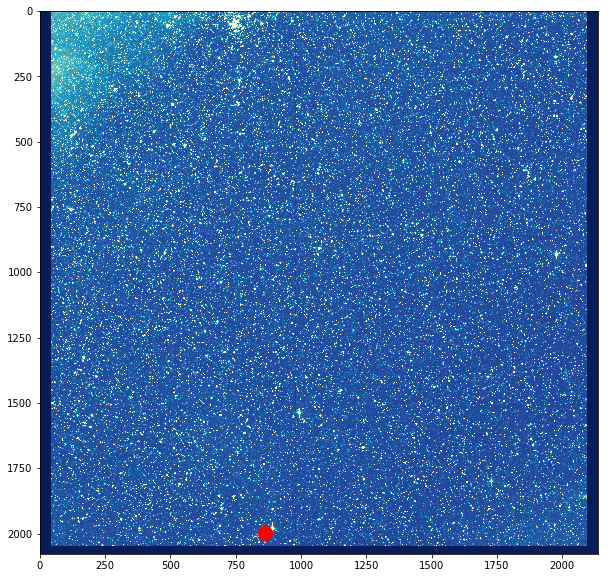

In [15]:
fig = plt.figure(figsize=(10,10))  
ax = fig.add_subplot(111)
ax.imshow(ffi_hdu[1].data,  cmap=plt.cm.YlGnBu_r, vmin=0, vmax=500)

px,py = ffi_wcs.all_world2pix([[tic_ra,tic_dec]],0)[0]
ax.scatter([px],[py],color="red",marker='o',s=200)

## Solution

### Open issue with astropy
    - Documentation update to warn about this
    - Suggest astropy return the maximum error due to ignoring sip coefficients, and perhaps issue a warning above some threshold, if practicable
    - Consider the merits/doability of implementing solving function in astropy
    
### Solve for wcs without SIP distortion
    - Clare Shanahan (STScI) has implemented a function that takes a matched list of x,y coordinates and ra,dec 
      coordinates and solves for the best fit WCS.
    - We can use it to make a "corrected" wcs at the cutout position and then plot.
    
#### Use full wcs to get the matched coordinates 

In [10]:
pix_inds = np.array(list(product(list(range(30)),list(range(25)))))
world_pix = cutout_wcs.all_pix2world(pix_inds,1)
coord_mapping = Table(names=['x','y','lon','lat'],data= [pix_inds[:,0],pix_inds[:,1],
                                                        world_pix[:,0],world_pix[:,1]])

In [11]:
cy,cx = cutout_img.shape
y,x = (cy+1)/2,(cx+1)/2
center_ra,center_dec = cutout_wcs.all_pix2world([[x,y]],1)[0]

In [12]:
correctedWcs = pixworld2wcs.wcs_pixworld2wcs(coord_mapping,proj_point=((x,y),(center_ra,center_dec)))
correctedWcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 107.4564243762776  -70.67095000162611  
CRPIX : 15.5  13.0  
PC1_1 PC1_2  : -0.004964693758380048  -0.0028548285463408435  
PC2_1 PC2_2  : 0.002820386829171814  -0.005059131539995117  
CDELT : 1.0  1.0  
NAXIS : 29  24

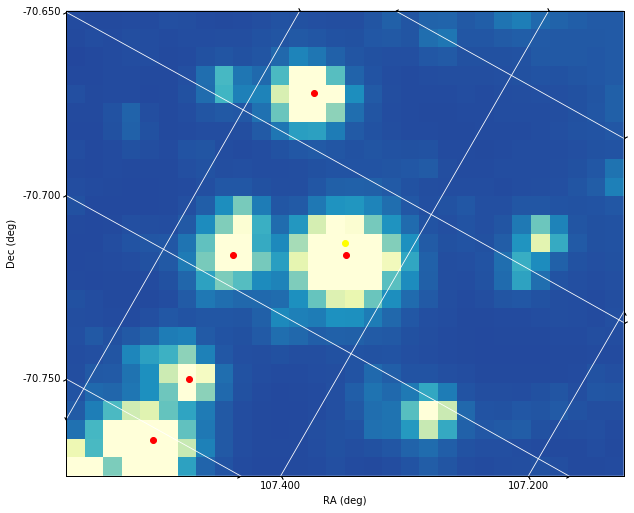

In [13]:
fig, ax = plt.subplots(subplot_kw={'projection':correctedWcs})
fig.set_size_inches(10,10)
plt.grid(color='white', ls='solid')
    
# Setup WCS axes.
xcoords = ax.coords[0]
ycoords = ax.coords[1]
xcoords.set_major_formatter('d.ddd')
ycoords.set_major_formatter('d.ddd')
xcoords.set_axislabel("RA (deg)")
ycoords.set_axislabel("Dec (deg)")
ax.imshow(cutout_img, cmap=plt.cm.YlGnBu_r,vmin=0,vmax=500)#,origin='lower')
ax.plot([tic_ra], [tic_dec], 'o', transform=ax.get_transform('icrs'),color="white")
ax.plot(correctedWcs.wcs.crval[0], correctedWcs.wcs.crval[1],'o',transform=ax.get_transform('icrs'),color="yellow")
ax.plot(nearbyStars[nearbyStars['Tmag'] < 12]['ra'],nearbyStars[nearbyStars['Tmag'] < 12]['dec'],
        'o',transform=ax.get_transform('icrs'),color="red")


plt.show()

## Next steps

- Open the issue in astropy
- Implement wcs solution in Astrocut/TESScut